In [41]:
import torch
import numpy as np
variable = "pr"
samples = torch.load(f"/r/scratch/groups/nm/downscaling/samples_cordexbench/Emulator_hist_future/ALPS/no-orog/maybritt_{variable}-ALPS-scalarin/samples_train.pt")

In [42]:
import matplotlib.pyplot as plt

In [43]:
samples.shape

torch.Size([14610, 1, 128, 128, 9])

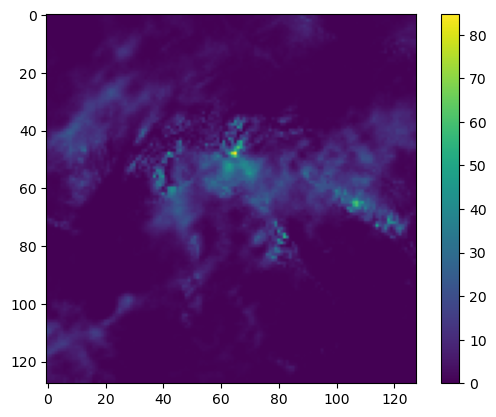

In [44]:
plt.imshow(samples[10,0,:,:, 0].cpu(), cmap='viridis')
plt.colorbar()

In [45]:
DATA_PATH = "/r/scratch/users/mschillinger/data/cordexbench/"
folder = "ALPS/ALPS_domain/train"
training_experiment = "Emulator_hist_future"
gcm_name = "CNRM-CM5"
period_training = "1961-1980_2080-2099"
hr_path = f'{DATA_PATH}/{folder}/{training_experiment}/target/pr_tasmax_{gcm_name}_{period_training}.nc'
hr_path

'/r/scratch/users/mschillinger/data/cordexbench//ALPS/ALPS_domain/train/Emulator_hist_future/target/pr_tasmax_CNRM-CM5_1961-1980_2080-2099.nc'

In [46]:
import xarray as xr
target = xr.open_dataset(hr_path)

In [47]:
target

<xarray.Dataset> Size: 2GB
Dimensions:  (time: 14610, y: 128, x: 128)
Coordinates:
  * time     (time) datetime64[ns] 117kB 1961-01-01T12:00:00 ... 2099-12-31T1...
    lon      (y, x) float64 131kB ...
    lat      (y, x) float64 131kB ...
  * x        (x) float64 1kB 2.062e+03 2.075e+03 ... 3.638e+03 3.65e+03
  * y        (y) float64 1kB 1.412e+03 1.425e+03 1.438e+03 ... 2.988e+03 3e+03
Data variables:
    tasmax   (time, y, x) float32 957MB ...
    pr       (time, y, x) float32 957MB ...
Attributes: (12/26)
    description:                    Created by xios
    title:                          Created by xios
    Conventions:                    CF-1.6
    creation_date:                  2018-10-24T11:26:47Z
    name:                           EUR-11_CNRM-CERFACS-CNRM-CM5_historical_r...
    institute_id:                   CNRM
    ...                             ...
    references:                     http://www.umr-cnrm.fr/spip.php?article12...
    comment:                        CORDEX Europe EUR-11 CNRM-ALADIN 6.3 L91 ...
    c3s_disclaimer:                 This data has been produced in the contex...
    driving_experiment_comment:     Known issue correction: this simulation (...
    frequency:                      day
    tracking_id:                    hdl:21.14103/e0344943-4520-4786-94f8-4cbf...

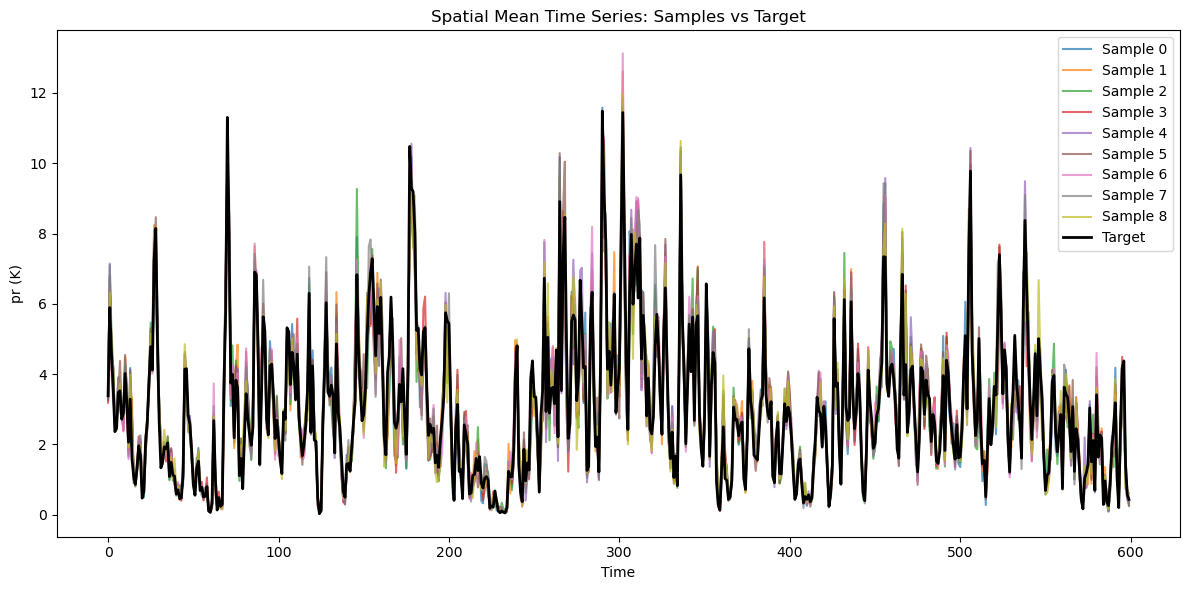

In [48]:
# Calculate spatial mean across y and x dimensions for samples and target
samples_mean = samples[:, :, :, :, :].mean(dim=(2, 3)) if hasattr(samples, 'mean') else samples[:, :, :, :, 0].cpu().numpy().reshape(samples.shape[0], samples.shape[1], -1).mean(axis=2)
target_mean = target[variable].mean(dim=('y', 'x'))

# Convert to numpy if needed
if hasattr(samples_mean, 'numpy'):
    samples_mean = samples_mean.numpy()
else:
    samples_mean = samples_mean.cpu().numpy() if hasattr(samples_mean, 'cpu') else samples_mean

# Plot time series
plt.figure(figsize=(12, 6))
for i in range(samples.shape[-1]):
    plt.plot(samples_mean[:600, ...,i], label=f'Sample {i}', alpha=0.7)
plt.plot(target_mean.values[:600], label='Target', linewidth=2, color='black')
plt.xlabel('Time')
plt.ylabel(f'{variable} (K)')
plt.title('Spatial Mean Time Series: Samples vs Target')
plt.legend()
plt.tight_layout()
plt.show()

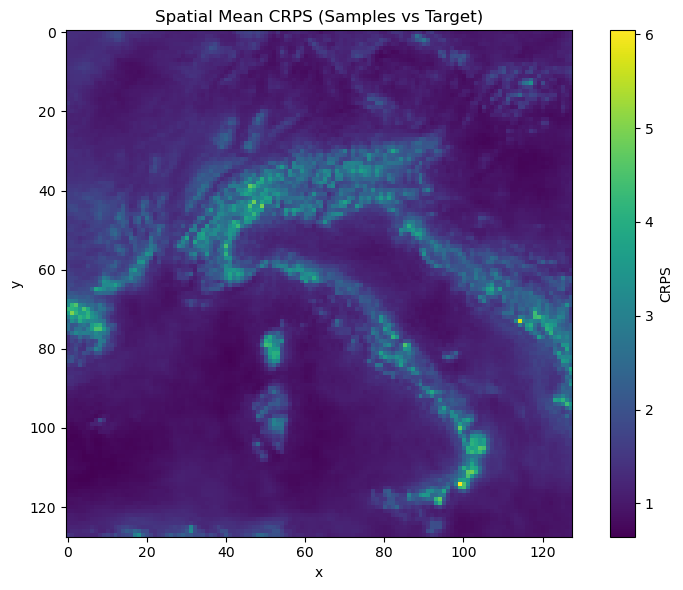

Spatial mean CRPS: 1.3654531


In [49]:
from properscoring import crps_ensemble

# Ensure samples and target are aligned in shape for CRPS calculation
# samples_mean: (time, 1, ensemble), target_mean: (time,)
# But we want CRPS over space, so use full spatial fields

# Get samples: (time, ensemble, y, x)
samples_np = samples.squeeze(1).cpu().numpy()
samples_np_subset = samples_np[:1000]  # (time, y, x, ensemble)
target_np = np.flip(target[variable].values, [1])
target_np_subset = target_np[:1000] # (time, y, x)

# Compute CRPS for each grid point and time
crps_map = crps_ensemble(target_np_subset, samples_np_subset)  # shape: (time, y, x)

# Average over time to get spatial CRPS map
crps_spatial = crps_map.mean(axis=0)  # shape: (y, x)

# Plot CRPS map
plt.figure(figsize=(8, 6))
plt.imshow(crps_spatial, cmap='viridis')
plt.colorbar(label='CRPS')
plt.title('Spatial Mean CRPS (Samples vs Target)')
plt.xlabel('x')
plt.ylabel('y')
plt.tight_layout()
plt.show()

# Print spatial mean CRPS (average over all grid points)
print("Spatial mean CRPS:", crps_spatial.mean())

CRPS also on test data

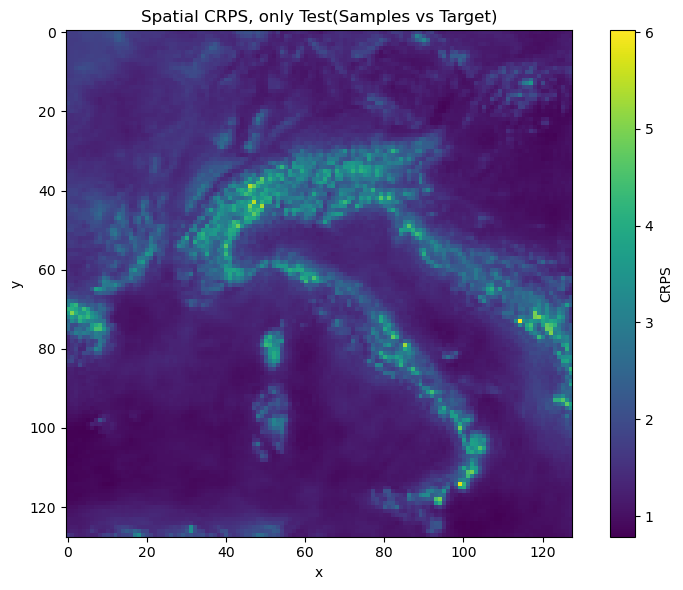

Spatial mean CRPS, only test: 1.5426648


In [50]:
from sklearn.model_selection import train_test_split
train_indices, test_indices = train_test_split(list(range(len(target_np))), test_size = 0.1, random_state = 42) # recover train test split from training

target_only_test = target_np[test_indices]
samples_only_test = samples_np[test_indices]

# Compute CRPS for each grid point and time
crps_map = crps_ensemble(target_only_test, samples_only_test)  # shape: (time, y, x)

# Average over time to get spatial CRPS map
crps_spatial = crps_map.mean(axis=0)  # shape: (y, x)

# Plot CRPS map
plt.figure(figsize=(8, 6))
plt.imshow(crps_spatial, cmap='viridis')
plt.colorbar(label='CRPS')
plt.title('Spatial CRPS, only Test(Samples vs Target)')
plt.xlabel('x')
plt.ylabel('y')
plt.tight_layout()
plt.show()

# Print spatial mean CRPS (average over all grid points)
print("Spatial mean CRPS, only test:", crps_spatial.mean())